In [2]:
data=spark.read.format('csv').options(header='true', inferSchema='true').load('C:/Users/User/Desktop/Accidents.csv')


In [3]:
data1=spark.read.format('csv').options(header='true', inferSchema='true').load('C:/Users/User/Desktop/Vehicles.csv')

In [4]:
data2=spark.read.format('csv').options(header='true', inferSchema='true').load('C:/Users/User/Desktop/Casualties.csv')

In [5]:
data1=data1.withColumnRenamed("Accident_Index","ID")
data2=data2.withColumnRenamed("Accident_Index","IDE")


In [7]:
merge = data.join(data1, data.Accident_Index == data1.ID)
merge.drop("ID")
full_merge = merge.join(data2, merge.Accident_Index == data2.IDE)
full_merge=full_merge.drop("IDE")
full_merge=full_merge.drop("ID")
len(full_merge.columns)



67

In [8]:
from pyspark.sql.functions import when
newsdf = full_merge.withColumn("Accident_Severity", when(full_merge["Accident_Severity"] == 3, 2).otherwise(full_merge["Accident_Severity"]))


In [9]:
newsdf.registerTempTable("TempTable")
mrtvy = sqlContext.sql('SELECT * FROM TempTable WHERE Accident_Severity = 1')
#mrtvy_pocet = mrtvy.count()
nemrtvy = sqlContext.sql('SELECT * FROM TempTable WHERE Accident_Severity = 2')
#nemrtvy_pocet = nemrtvy.count()



In [10]:
vzorka_mrtvy = mrtvy.sampleBy("Accident_Severity", fractions = {1: 0.05}, seed = 0)
vzorka_nemrtvy = nemrtvy.sampleBy("Accident_Severity", fractions = {2: 0.05}, seed = 0)

In [11]:

groupZeros = vzorka_nemrtvy.groupBy("Accident_Severity").count().orderBy("Accident_Severity").show()

+-----------------+------+
|Accident_Severity| count|
+-----------------+------+
|                2|210374|
+-----------------+------+



In [108]:
vzorka_mrtvy.count()

4203

In [12]:
vzorka_cela = vzorka_mrtvy.union(vzorka_nemrtvy)

In [34]:
vzorka_cela.count()

214577

In [ ]:
vzorka_cela.describe("Age_of_Vehicle").show()

In [38]:
from pyspark.sql.functions import mean as _mean, col

df_stats = vzorka_cela.select(
    _mean(col('Age_of_Driver')).alias('mean')).collect()

mean = df_stats[0]['mean']


In [60]:
names = vzorka_cela.schema.names
t = zip(names,correlations)
#print(t)
#print("-------------------")
tt = spark.createDataFrame(t)
#tt.show()

tt.registerTempTable("TempTable")
atributy_table = sqlContext.sql('SELECT * FROM TempTable WHERE _2 > 0.05 OR _2 <-0.05')
atributy = atributy_table.select("_2")
atributy_table.show()

+--------------------+--------------------+
|                  _1|                  _2|
+--------------------+--------------------+
|   Accident_Severity|                 1.0|
|  Number_of_Vehicles| -0.0636911069269698|
|Number_of_Casualties|  -0.120666368557851|
|     Junction_Detail|0.051871110687382205|
|    Junction_Control| 0.07414108021980692|
|Did_Police_Office...| 0.05657186361984509|
|   Junction_Location| 0.05314717297823542|
|Skidding_and_Over...|-0.05192407596094772|
|Hit_Object_off_Ca...|-0.05299760866808702|
|   Casualty_Severity| 0.42392624071726726|
+--------------------+--------------------+



In [40]:
bezprazdnych = vzorka_cela.withColumn("Age_of_Driver", when(vzorka_cela["Age_of_Driver"] == -1, mean).otherwise(vzorka_cela["Age_of_Driver"]))


In [16]:
vzorka_cela   = vzorka_cela.drop("Location_Easting_OSGR",
					 "Location_Northing_OSGR",
					"Longitude",
					 "Latitude",
					 "Local_Authority_(District)",
					 "1st_Road_Class",
					 "1st_Road_Number",
					 "Road_Type",
					 "Speed_limit",
					 "2nd_Road_Class",
					 "2nd_Road_Number",
					"Pedestrian_Crossing-Human_Control",
					"Pedestrian_Crossing-Physical_Facilities",
					 "Special_Conditions_at_Site",
					 "Carriageway_Hazards",
					 "Urban_or_Rural_Area",
					 "Vehicle_Reference",
					 "Towing_and_Articulation",
					 "Vehicle_Manoeuvre",
					"Vehicle_Location-Restricted_Lane",
					 "Vehicle_Leaving_Carriageway",
					 "Was_Vehicle_Left_Hand_Drive?",
					 "Journey_Purpose_of_Driver",
					 "Propulsion_Code",
					 "Driver_IMD_Decile",
					 "Driver_Home_Area_Type",
					"Vehicle_Reference",
					 "Casualty_Reference",
					 "Police_Force",
                    "Day_of_Week",
                                 "Light_Conditions",
                                 "Weather_Conditions",
                                 "Road_Surface_Conditions",
                                 "Vehicle_Type",
                                 "Hit_Object_in_Carriageway",
                                 "1st_Point_of_Impact",
                                 "Sex_of_Driver",
                                 "Age_of_Driver",
                                 "Age_Band_of_Driver",
                                 "Engine_Capacity_(CC)",
                                 "Age_of_Vehicle",
                                 "Casualty_Class",
                                 "Sex_of_Casualty",
                                 "Age_of_Casualty",
                                 "Age_Band_of_Casualty",
                                 "Casualty_Severity",
                                 "Pedestrian_Location",
                                 "Pedestrian_Movement",
                                 "Car_Passenger",
                                 "Bus_or_Coach_Passenger",
                                 "Pedestrian_Road_Maintenance_Worker",
                                 "Casualty_Type",
                                 "Casualty_Home_Area_Type",
					 )



In [64]:
vzorka_cela.take(1)

[Row(Accident_Severity=1, Number_of_Vehicles=2, Number_of_Casualties=3, Junction_Detail=0, Junction_Control=-1, Did_Police_Officer_Attend_Scene_of_Accident=1, Junction_Location=0, Skidding_and_Overturning=0, Hit_Object_off_Carriageway=0)]

In [23]:
print "***************          DESICION TREE             ***************"
from pyspark.ml.classification import DecisionTreeClassifier, DecisionTreeClassificationModel
from pyspark.ml.feature import VectorAssembler
vector_data = VectorAssembler(inputCols=["Number_of_Vehicles", "Number_of_Casualties", "Junction_Detail", "Junction_Control", "Did_Police_Officer_Attend_Scene_of_Accident", "Junction_Location","Skidding_and_Overturning","Hit_Object_off_Carriageway"],
        outputCol="features").transform(vzorka_cela)
training_data, test_data = vector_data.randomSplit([0.7, 0.3], seed=123)
 
tree_classifier = DecisionTreeClassifier(featuresCol="features",labelCol="Accident_Severity",impurity="entropy",maxDepth=10, maxBins=100) 
 
tree_model = tree_classifier.fit(training_data)
 
predictions = tree_model.transform(test_data)


***************          DESICION TREE             ***************


KeyboardInterrupt: 

In [68]:
print(tree_model.toDebugString)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_42d09731784afb4bc376) of depth 10 with 767 nodes
  If (feature 1 <= 3.0)
   If (feature 4 <= 1.0)
    If (feature 3 <= 0.0)
     If (feature 1 <= 1.0)
      If (feature 0 <= 1.0)
       If (feature 6 <= 1.0)
        If (feature 7 <= 3.0)
         If (feature 5 <= -1.0)
          If (feature 7 <= 0.0)
           If (feature 6 <= 0.0)
            Predict: 2.0
           Else (feature 6 > 0.0)
            Predict: 2.0
          Else (feature 7 > 0.0)
           Predict: 2.0
         Else (feature 5 > -1.0)
          If (feature 7 <= 2.0)
           If (feature 6 <= 0.0)
            Predict: 2.0
           Else (feature 6 > 0.0)
            Predict: 2.0
          Else (feature 7 > 2.0)
           If (feature 6 <= 0.0)
            Predict: 2.0
           Else (feature 6 > 0.0)
            Predict: 2.0
        Else (feature 7 > 3.0)
         If (feature 7 <= 4.0)
          If (feature 3 <= -1.0)
           If (feature 6 <= 0.0)
    

In [69]:
test_error = predictions.filter(predictions["prediction"] != predictions["Accident_Severity"]).count() / float(test_data.count())
print "Testing error: {0:.4f}".format(test_error)

Testing error: 0.0194


In [81]:
from pyspark.ml.classification import LinearSVC
vzorka_cela.withColumn("Accident_Severity", when(vzorka_cela["Accident_Severity"] == -1, 2).otherwise(vzorka_cela["Accident_Severity"]))
vector_data = VectorAssembler(inputCols=["Number_of_Vehicles", "Number_of_Casualties", "Junction_Detail", "Junction_Control", "Did_Police_Officer_Attend_Scene_of_Accident", "Junction_Location","Skidding_and_Overturning","Hit_Object_off_Carriageway"],
        outputCol="features").transform(vzorka_cela)
svm_classifier = LinearSVC(
        featuresCol="features",             
        labelCol="Accident_Severity")                  

svm_model = svm_classifier.fit(training_data)

predictions = svm_model.transform(test_data)

test_error = predictions.filter(predictions["prediction"] != predictions["Accident_Severity"]).count() / float(test_data.count())
print "Testing error: {0:.4f}".format(test_error)

IllegalArgumentException: u'requirement failed: LinearSVC only supports binary classification. 3 classes detected in LinearSVC_41e295f443ff72d430d0__labelCol'

In [108]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.linalg import Vectors
indexer = StringIndexer(inputCol="class", outputCol="label")
encoder=OneHotEncoder(inputCol="label", outputCol="labelVec")
vectorAssembler = VectorAssembler(inputCols=["Number_of_Vehicles", "Number_of_Casualties", "Junction_Detail", "Junction_Control", "Did_Police_Officer_Attend_Scene_of_Accident", "Junction_Location","Skidding_and_Overturning","Hit_Object_off_Carriageway"],
        outputCol="features")
normalizer= Normalizer(inputCol="features",outputCol="features_norm" ,p=1.0)
from pyspark.ml.classification import LinearSVC
lsvc=LinearSVC(maxIter=10)
#vzorka_cela.createOrReplaceTempView("df")
#df_two_class=spark.sql("select * from df where class in ('Accident_severity' ,'Skidding_and_Overturning') ")
#splits=df_two_class.randomSplit(0.8, 0.2)
#df_train=splits[0]
#df_test=splits[1]
from pyspark.ml import Pipeline
pipeline=Pipeline(stages=[indexer, encoder, vectorAssembler, normalizer, lsvc])
model=pipeline.fit(training_data)
prediction= model.transform(training_data)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(prediction)

IllegalArgumentException: u'Field "class" does not exist.'

In [100]:
from pyspark.mllib.classification import SVMWithSGD, SVMModel
svmModel = SVMWithSGD.train(training_data, iterations=5)

prediction = svmModel.predict(test_data.map(lambda p: p.features)) 	#predikovane hodnoty
predic = [x for x in prediction.toLocalIterator()]					#predikovana hodnota pretransformovana na list
predic = [float(i) for i in predic]
labels = test_data.map(lambda p: p.label)							#povodne hodnoty
label = [x for x in labels.toLocalIterator()]						#povodne hodnoty pretransformovane na list
SVM = matthews_correlation(label, predic)	

TypeError: data should be an RDD of LabeledPoint, but got <class 'pyspark.sql.types.Row'>

In [82]:
#bayes
from pyspark.ml .classification import NaiveBayes, NaiveBayesModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
 
# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1.0, modelType="multinomial",featuresCol="features", labelCol="Accident_Severity")
 
# train the model
model = nb.fit(training_data)
 
predictions = model.transform(test_data)
#predictions.show()
 
evaluator = MulticlassClassificationEvaluator(labelCol="Accident_Severity", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

Py4JJavaError: An error occurred while calling o994.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 484.0 failed 1 times, most recent failure: Lost task 1.0 in stage 484.0 (TID 40356, localhost, executor driver): java.lang.IllegalArgumentException: requirement failed: Naive Bayes requires nonnegative feature values but found [1.0,2.0,0.0,-1.0,1.0,0.0,1.0,7.0].
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.classification.NaiveBayes$.requireNonnegativeValues(NaiveBayes.scala:233)
	at org.apache.spark.ml.classification.NaiveBayes$$anonfun$4.apply(NaiveBayes.scala:141)
	at org.apache.spark.ml.classification.NaiveBayes$$anonfun$4.apply(NaiveBayes.scala:141)
	at org.apache.spark.ml.classification.NaiveBayes$$anonfun$7.apply(NaiveBayes.scala:166)
	at org.apache.spark.ml.classification.NaiveBayes$$anonfun$7.apply(NaiveBayes.scala:164)
	at org.apache.spark.util.collection.ExternalSorter$$anonfun$5.apply(ExternalSorter.scala:189)
	at org.apache.spark.util.collection.ExternalSorter$$anonfun$5.apply(ExternalSorter.scala:188)
	at org.apache.spark.util.collection.AppendOnlyMap.changeValue(AppendOnlyMap.scala:150)
	at org.apache.spark.util.collection.SizeTrackingAppendOnlyMap.changeValue(SizeTrackingAppendOnlyMap.scala:32)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:194)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1499)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1487)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1486)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1486)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1714)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1669)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1658)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:630)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2022)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2043)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2062)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2087)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:936)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:935)
	at org.apache.spark.ml.classification.NaiveBayes.trainWithLabelCheck(NaiveBayes.scala:174)
	at org.apache.spark.ml.classification.NaiveBayes.train(NaiveBayes.scala:118)
	at org.apache.spark.ml.classification.NaiveBayes.train(NaiveBayes.scala:78)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:82)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.lang.IllegalArgumentException: requirement failed: Naive Bayes requires nonnegative feature values but found [1.0,2.0,0.0,-1.0,1.0,0.0,1.0,7.0].
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.classification.NaiveBayes$.requireNonnegativeValues(NaiveBayes.scala:233)
	at org.apache.spark.ml.classification.NaiveBayes$$anonfun$4.apply(NaiveBayes.scala:141)
	at org.apache.spark.ml.classification.NaiveBayes$$anonfun$4.apply(NaiveBayes.scala:141)
	at org.apache.spark.ml.classification.NaiveBayes$$anonfun$7.apply(NaiveBayes.scala:166)
	at org.apache.spark.ml.classification.NaiveBayes$$anonfun$7.apply(NaiveBayes.scala:164)
	at org.apache.spark.util.collection.ExternalSorter$$anonfun$5.apply(ExternalSorter.scala:189)
	at org.apache.spark.util.collection.ExternalSorter$$anonfun$5.apply(ExternalSorter.scala:188)
	at org.apache.spark.util.collection.AppendOnlyMap.changeValue(AppendOnlyMap.scala:150)
	at org.apache.spark.util.collection.SizeTrackingAppendOnlyMap.changeValue(SizeTrackingAppendOnlyMap.scala:32)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:194)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


In [86]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
 
gbt_reg = GBTRegressor(featuresCol="features", labelCol="Accident_Severity", maxIter=10, maxBins=100)
 
# Train model. 
model = gbt_reg.fit(training_data)
 
# Make predictions.
predictions = model.transform(test_data)
 
test_error = predictions.filter(predictions["prediction"] != predictions["Accident_Severity"]).count() / float(test_data.count())
print "Testing error: {0:.4f}".format(test_error)
 
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="Accident_Severity", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Testing error: 1.0000
Root Mean Squared Error (RMSE) on test data = 0.134178


In [97]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol="features", k=3, seed=1234)
kmeans_model = kmeans.fit(training_data)

clusters = kmeans_model.transform(training_data)
clusters.show()

print(kmeans_model.clusterCenters()[0])


+-----------------+------------------+--------------------+---------------+----------------+-------------------------------------------+-----------------+------------------------+--------------------------+--------------------+----------+
|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|Junction_Detail|Junction_Control|Did_Police_Officer_Attend_Scene_of_Accident|Junction_Location|Skidding_and_Overturning|Hit_Object_off_Carriageway|            features|prediction|
+-----------------+------------------+--------------------+---------------+----------------+-------------------------------------------+-----------------+------------------------+--------------------------+--------------------+----------+
|                1|                 1|                   1|              1|               4|                                          1|                3|                       0|                         0|[1.0,1.0,1.0,4.0,...|         0|
|                1|                 1|      

KMeans_471cafd5776f37fa25f6

DataFrame[Accident_Severity: int, Number_of_Vehicles: int, Number_of_Casualties: int, Junction_Detail: int, Junction_Control: int, Did_Police_Officer_Attend_Scene_of_Accident: int, Junction_Location: int, Skidding_and_Overturning: int, Hit_Object_off_Carriageway: int]

In [98]:
display(kmeans_model, vzorka_cela)

KMeans_471cafd5776f37fa25f6

DataFrame[Accident_Severity: int, Number_of_Vehicles: int, Number_of_Casualties: int, Junction_Detail: int, Junction_Control: int, Did_Police_Officer_Attend_Scene_of_Accident: int, Junction_Location: int, Skidding_and_Overturning: int, Hit_Object_off_Carriageway: int]

ValueError: setting an array element with a sequence.

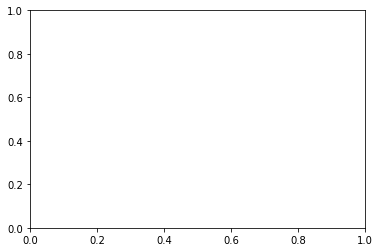

In [96]:
plt.scatter(clusters, kmeans_model)

In [99]:
vzorka_cela.take(1)

[Row(Accident_Severity=1, Number_of_Vehicles=2, Number_of_Casualties=3, Junction_Detail=0, Junction_Control=-1, Did_Police_Officer_Attend_Scene_of_Accident=1, Junction_Location=0, Skidding_and_Overturning=0, Hit_Object_off_Carriageway=0)]

In [103]:
features

NameError: name 'features' is not defined

In [19]:
from pyspark.sql import Row
import urllib

# stiahneme si dáta z internetu a uložíme ich do pracovného adresára
urllib.urlretrieve("http://people.tuke.sk/martin.sarnovsky/tsvd/files/iris.csv", "iris.csv")

# ‘iris’ je jednoduchá dátová množina pre klasifikáciu do troch tried
# príklady popisujú tri druhy rastlín (kosatcov) podľa rozmerov ich kvetov (štyry vstupné číselné atribúty)

# načítame dáta a premapujeme ich na objekty typu ‘Row’
raw_data = sc.textFile("iris.csv")
csv_data = raw_data.map(lambda x: x.split(","))

In [21]:
csv_data.take(100)

[[u'5.1', u'3.5', u'1.4', u'0.2', u'iris-setosa'],
 [u'4.9', u'3.0', u'1.4', u'0.2', u'iris-setosa'],
 [u'4.7', u'3.2', u'1.3', u'0.2', u'iris-setosa'],
 [u'4.6', u'3.1', u'1.5', u'0.2', u'iris-setosa'],
 [u'5.0', u'3.6', u'1.4', u'0.2', u'iris-setosa'],
 [u'5.4', u'3.9', u'1.7', u'0.4', u'iris-setosa'],
 [u'4.6', u'3.4', u'1.4', u'0.3', u'iris-setosa'],
 [u'5.0', u'3.4', u'1.5', u'0.2', u'iris-setosa'],
 [u'4.4', u'2.9', u'1.4', u'0.2', u'iris-setosa'],
 [u'4.9', u'3.1', u'1.5', u'0.1', u'iris-setosa'],
 [u'5.4', u'3.7', u'1.5', u'0.2', u'iris-setosa'],
 [u'4.8', u'3.4', u'1.6', u'0.2', u'iris-setosa'],
 [u'4.8', u'3.0', u'1.4', u'0.1', u'iris-setosa'],
 [u'4.3', u'3.0', u'1.1', u'0.1', u'iris-setosa'],
 [u'5.8', u'4.0', u'1.2', u'0.2', u'iris-setosa'],
 [u'5.7', u'4.4', u'1.5', u'0.4', u'iris-setosa'],
 [u'5.4', u'3.9', u'1.3', u'0.4', u'iris-setosa'],
 [u'5.1', u'3.5', u'1.4', u'0.3', u'iris-setosa'],
 [u'5.7', u'3.8', u'1.7', u'0.3', u'iris-setosa'],
 [u'5.1', u'3.8', u'1.5', u'0.3

In [22]:
atributes = ["Number_of_Vehicles",
			 "Number_of_Casualties",
			 "Junction_Detail",
			 "Junction_Control",
			 "Did_Police_Officer_Attend_Scene_of_Accident",
			 "Junction_Location",
			 "Skidding_and_Overturning",
			 "Hit_Object_off_Carriageway",
			 "Accident_Severity"]

nova_vzorka = vzorka_cela.select(atributes)
names2 = nova_vzorka.schema.names

for name in names2:
	type_counts = nova_vzorka.groupBy(name).count()
	type_counts = type_counts.orderBy(["count", name], ascending=[0, 1])

	moj_list = type_counts.select(name).collect()
	najcastejsia_hodnota = moj_list[0][0]

	nova_vzorka = nova_vzorka.withColumn(name, when(nova_vzorka[name] == -1,  najcastejsia_hodnota).otherwise(nova_vzorka[name]))


In [26]:
from pyspark.ml .classification import NaiveBayes, NaiveBayesModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
vector_data = VectorAssembler(inputCols=["Number_of_Vehicles", "Number_of_Casualties", "Junction_Detail", "Junction_Control", "Did_Police_Officer_Attend_Scene_of_Accident", "Junction_Location","Skidding_and_Overturning","Hit_Object_off_Carriageway"],
        outputCol="features").transform(nova_vzorka) 
training_data, test_data = vector_data.randomSplit([0.7, 0.3], seed=123)
# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1.0, modelType="multinomial",featuresCol="features", labelCol="Accident_Severity")
 
# train the model
model = nb.fit(training_data)
 
predictions = model.transform(test_data)
#predictions.show()
 
evaluator = MulticlassClassificationEvaluator(labelCol="Accident_Severity", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.0140229635713


In [25]:
for name in names2:
	x = nova_vzorka.filter(nova_vzorka[name] == -1).count()
	print(x)


0
0
0
0
0
0
0
0


KeyboardInterrupt: 

In [28]:
nova_vzorka.take(1)

[Row(Number_of_Vehicles=2, Number_of_Casualties=3, Junction_Detail=0, Junction_Control=4, Did_Police_Officer_Attend_Scene_of_Accident=1, Junction_Location=0, Skidding_and_Overturning=0, Hit_Object_off_Carriageway=0, Accident_Severity=1)]

In [29]:
SVM_df = nova_vzorka.withColumn("Accident_Severity", when(nova_vzorka["Accident_Severity"] == 1, 0).otherwise(nova_vzorka["Accident_Severity"]))


In [30]:
SVM_df = nova_vzorka.withColumn("Accident_Severity", when(nova_vzorka["Accident_Severity"] == 2, 1).otherwise(nova_vzorka["Accident_Severity"]))


In [32]:
from pyspark.ml.classification import LinearSVC
SVM_vector_data = VectorAssembler(inputCols=["Number_of_Vehicles", "Number_of_Casualties", "Junction_Detail", "Junction_Control", "Did_Police_Officer_Attend_Scene_of_Accident", "Junction_Location","Skidding_and_Overturning","Hit_Object_off_Carriageway"],
        outputCol="features").transform(SVM_df) 
SVMtraining_data, SVMtest_data = SVM_vector_data.randomSplit([0.7, 0.3], seed=123)
svm_classifier = LinearSVC(
        featuresCol="features",             
        labelCol="Accident_Severity")                  

svm_model = svm_classifier.fit(SVMtraining_data)

predictions = svm_model.transform(SVMtest_data)

test_error = predictions.filter(predictions["prediction"] != predictions["Accident_Severity"]).count() / float(SVMtest_data.count())
print "Testing error: {0:.4f}".format(test_error)

Testing error: 0.0000
